# Denoising Diffusion Probabilistic Model

Kernel Author: Minsu Kang

Email: mskang1478@gmail.com

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [5]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [6]:
class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y
    
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

### Define Gaussian Diffusion

In [7]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)
                                     
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
    
    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t): 
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return noisy_sample.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    
    
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


### Visualizing forward process

In [9]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [10]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

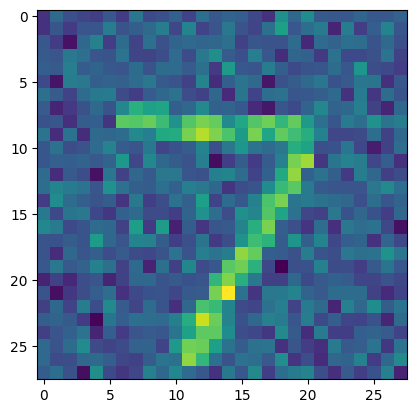

In [11]:
show_image(perturbed_images, idx=0)

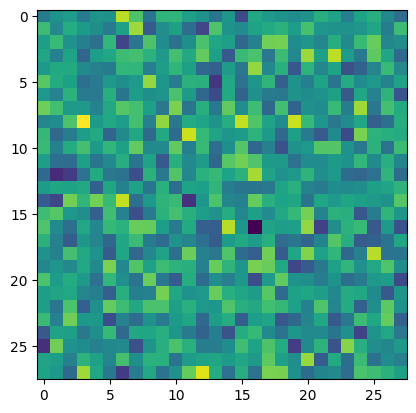

In [12]:
show_image(perturbed_images, idx=1)

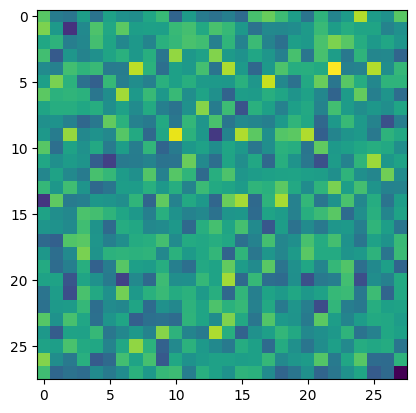

In [13]:
show_image(perturbed_images, idx=2)

## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)

In [14]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)
        
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


100%|██████████| 469/469 [01:54<00:00,  4.11it/s]

	Epoch 1 complete! 	Denoising Loss:  0.09139186992811468



100%|██████████| 469/469 [01:56<00:00,  4.03it/s]

	Epoch 2 complete! 	Denoising Loss:  0.03912439342970268



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 3 complete! 	Denoising Loss:  0.03502223011838575



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 4 complete! 	Denoising Loss:  0.033074180301055946



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 5 complete! 	Denoising Loss:  0.031659205284956686



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 6 complete! 	Denoising Loss:  0.030394927514955785



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 7 complete! 	Denoising Loss:  0.029586381764493436



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 8 complete! 	Denoising Loss:  0.029004782382558044



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 9 complete! 	Denoising Loss:  0.02870566586557871



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 10 complete! 	Denoising Loss:  0.028257252497232366



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 11 complete! 	Denoising Loss:  0.027686360244376537



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 12 complete! 	Denoising Loss:  0.02737191493392118



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 13 complete! 	Denoising Loss:  0.027033732169204287



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 14 complete! 	Denoising Loss:  0.02685160856916864



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 15 complete! 	Denoising Loss:  0.026883056251984887



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 16 complete! 	Denoising Loss:  0.026687104613162003



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 17 complete! 	Denoising Loss:  0.026394207663356494



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 18 complete! 	Denoising Loss:  0.026203634046241004



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 19 complete! 	Denoising Loss:  0.025993234764498014



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 20 complete! 	Denoising Loss:  0.025735970514898118



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 21 complete! 	Denoising Loss:  0.025583152941818166



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 22 complete! 	Denoising Loss:  0.02552096575944342



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 23 complete! 	Denoising Loss:  0.02544535357011562



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 24 complete! 	Denoising Loss:  0.025343046635070927



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 25 complete! 	Denoising Loss:  0.025107728771101206



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 26 complete! 	Denoising Loss:  0.025201152803169355



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 27 complete! 	Denoising Loss:  0.02534737057076433



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 28 complete! 	Denoising Loss:  0.02478506017683281



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 29 complete! 	Denoising Loss:  0.024953264018727675



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 30 complete! 	Denoising Loss:  0.024837105992672026



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 31 complete! 	Denoising Loss:  0.024775144520701252



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 32 complete! 	Denoising Loss:  0.024657960957250535



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 33 complete! 	Denoising Loss:  0.02441827945299765



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 34 complete! 	Denoising Loss:  0.024653083690577466



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 35 complete! 	Denoising Loss:  0.024237788121144358



100%|██████████| 469/469 [01:57<00:00,  3.99it/s]

	Epoch 36 complete! 	Denoising Loss:  0.024168311015296824



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 37 complete! 	Denoising Loss:  0.024355869851688035



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 38 complete! 	Denoising Loss:  0.024293917883983534



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 39 complete! 	Denoising Loss:  0.023945826249053843



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 40 complete! 	Denoising Loss:  0.024146587022731446



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 41 complete! 	Denoising Loss:  0.024054990269434758



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 42 complete! 	Denoising Loss:  0.02392732482164716



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 43 complete! 	Denoising Loss:  0.02412474129953955



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 44 complete! 	Denoising Loss:  0.023715408391550057



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 45 complete! 	Denoising Loss:  0.023693229569297317



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 46 complete! 	Denoising Loss:  0.023961120812445242



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 47 complete! 	Denoising Loss:  0.023891590639121003



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 48 complete! 	Denoising Loss:  0.023641266633207217



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 49 complete! 	Denoising Loss:  0.023648471790405676



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 50 complete! 	Denoising Loss:  0.023753292834720552



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 51 complete! 	Denoising Loss:  0.023708050372079015



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 52 complete! 	Denoising Loss:  0.02365999698686676



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 53 complete! 	Denoising Loss:  0.02357906736353906



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 54 complete! 	Denoising Loss:  0.023593562842211407



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 55 complete! 	Denoising Loss:  0.02346834114107948



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 56 complete! 	Denoising Loss:  0.023374447006031744



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 57 complete! 	Denoising Loss:  0.023174548135576848



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 58 complete! 	Denoising Loss:  0.023493600607268576



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 59 complete! 	Denoising Loss:  0.023359292111176457



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 60 complete! 	Denoising Loss:  0.02319498818057279



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 61 complete! 	Denoising Loss:  0.02334097970643232



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 62 complete! 	Denoising Loss:  0.023386929301608704



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 63 complete! 	Denoising Loss:  0.02315629729762291



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 64 complete! 	Denoising Loss:  0.02331167869429048



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 65 complete! 	Denoising Loss:  0.02327972336903087



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 66 complete! 	Denoising Loss:  0.023135170694759004



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 67 complete! 	Denoising Loss:  0.023039099083751693



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 68 complete! 	Denoising Loss:  0.0232334506427312



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 69 complete! 	Denoising Loss:  0.023014973116736125



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 70 complete! 	Denoising Loss:  0.023163752140811622



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 71 complete! 	Denoising Loss:  0.02263662208500517



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 72 complete! 	Denoising Loss:  0.02317252790587198



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 73 complete! 	Denoising Loss:  0.022924306764641505



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 74 complete! 	Denoising Loss:  0.022919351453932688



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 75 complete! 	Denoising Loss:  0.022884595576021023



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 76 complete! 	Denoising Loss:  0.022991559679150328



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 77 complete! 	Denoising Loss:  0.022693624501076773



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 78 complete! 	Denoising Loss:  0.02272201995922523



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 79 complete! 	Denoising Loss:  0.022891840724370036



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 80 complete! 	Denoising Loss:  0.02278678084954492



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 81 complete! 	Denoising Loss:  0.022909168223651428



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 82 complete! 	Denoising Loss:  0.022823874999840673



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 83 complete! 	Denoising Loss:  0.022754538513751876



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 84 complete! 	Denoising Loss:  0.022494891757925607



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 85 complete! 	Denoising Loss:  0.022762503502810866



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 86 complete! 	Denoising Loss:  0.02241631240870517



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 87 complete! 	Denoising Loss:  0.02274462935498828



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 88 complete! 	Denoising Loss:  0.022695303022957



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 89 complete! 	Denoising Loss:  0.02268130030347687



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 90 complete! 	Denoising Loss:  0.022736632507931218



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 91 complete! 	Denoising Loss:  0.022469955424849804



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 92 complete! 	Denoising Loss:  0.02257943281935703



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 93 complete! 	Denoising Loss:  0.02233141419501641



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 94 complete! 	Denoising Loss:  0.02270395508330538



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 95 complete! 	Denoising Loss:  0.022738439361286215



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 96 complete! 	Denoising Loss:  0.022451482854512893



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 97 complete! 	Denoising Loss:  0.022494053742728937



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 98 complete! 	Denoising Loss:  0.022410569358298667



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 99 complete! 	Denoising Loss:  0.022469485902951822



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 100 complete! 	Denoising Loss:  0.022190978583426047



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 101 complete! 	Denoising Loss:  0.022474240911646914



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 102 complete! 	Denoising Loss:  0.022638408347773246



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 103 complete! 	Denoising Loss:  0.022250157581944752



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 104 complete! 	Denoising Loss:  0.02233978552130871



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 105 complete! 	Denoising Loss:  0.022399800260447793



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 106 complete! 	Denoising Loss:  0.02213004781689463



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 107 complete! 	Denoising Loss:  0.02244558705128411



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 108 complete! 	Denoising Loss:  0.022529518174039375



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 109 complete! 	Denoising Loss:  0.02233402703442953



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 110 complete! 	Denoising Loss:  0.022330341689511497



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 111 complete! 	Denoising Loss:  0.022533091216976952



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 112 complete! 	Denoising Loss:  0.022341353150132377



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 113 complete! 	Denoising Loss:  0.022408354585655987



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 114 complete! 	Denoising Loss:  0.02197344704833614



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 115 complete! 	Denoising Loss:  0.02216131691263718



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 116 complete! 	Denoising Loss:  0.022179138398944184



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 117 complete! 	Denoising Loss:  0.022202657199361257



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 118 complete! 	Denoising Loss:  0.022403077443297476



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 119 complete! 	Denoising Loss:  0.022132143045926832



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 120 complete! 	Denoising Loss:  0.022251445561265334



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 121 complete! 	Denoising Loss:  0.022299508231843256



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 122 complete! 	Denoising Loss:  0.021984618744199984



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 123 complete! 	Denoising Loss:  0.022152215777697343



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 124 complete! 	Denoising Loss:  0.022233243844607193



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 125 complete! 	Denoising Loss:  0.022238942832311887



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 126 complete! 	Denoising Loss:  0.022116597725922227



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 127 complete! 	Denoising Loss:  0.022161436633358143



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 128 complete! 	Denoising Loss:  0.022158038864135105



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 129 complete! 	Denoising Loss:  0.022137472010018606



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 130 complete! 	Denoising Loss:  0.02195015971142894



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 131 complete! 	Denoising Loss:  0.021968714047111888



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 132 complete! 	Denoising Loss:  0.021846036217772424



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 133 complete! 	Denoising Loss:  0.02209256064847239



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 134 complete! 	Denoising Loss:  0.02221344005014015



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 135 complete! 	Denoising Loss:  0.022098564956751134



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 136 complete! 	Denoising Loss:  0.02178285098992861



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 137 complete! 	Denoising Loss:  0.0219907187200032



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 138 complete! 	Denoising Loss:  0.021908585543338306



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 139 complete! 	Denoising Loss:  0.0218956850321852



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 140 complete! 	Denoising Loss:  0.022102399269500986



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 141 complete! 	Denoising Loss:  0.02211654453108517



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 142 complete! 	Denoising Loss:  0.02188790995333121



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 143 complete! 	Denoising Loss:  0.021929183463430684



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 144 complete! 	Denoising Loss:  0.021856698870229032



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 145 complete! 	Denoising Loss:  0.021764842570464835



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 146 complete! 	Denoising Loss:  0.021725219357997563



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 147 complete! 	Denoising Loss:  0.02181431696487543



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 148 complete! 	Denoising Loss:  0.022031452586380843



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 149 complete! 	Denoising Loss:  0.02202130660104255



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 150 complete! 	Denoising Loss:  0.02186749388392155



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 151 complete! 	Denoising Loss:  0.021991413476693835



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 152 complete! 	Denoising Loss:  0.021982731552332893



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 153 complete! 	Denoising Loss:  0.022171012649280775



100%|██████████| 469/469 [01:57<00:00,  3.98it/s]

	Epoch 154 complete! 	Denoising Loss:  0.021812360847177796



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 155 complete! 	Denoising Loss:  0.021708543808398467



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 156 complete! 	Denoising Loss:  0.02187324657988472



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 157 complete! 	Denoising Loss:  0.021681009927111812



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 158 complete! 	Denoising Loss:  0.0218910298939062



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 159 complete! 	Denoising Loss:  0.021735653422502242



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 160 complete! 	Denoising Loss:  0.021878652274608612



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 161 complete! 	Denoising Loss:  0.021561407014472872



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 162 complete! 	Denoising Loss:  0.021770036968394604



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 163 complete! 	Denoising Loss:  0.021750860176900894



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 164 complete! 	Denoising Loss:  0.02184277443955533



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 165 complete! 	Denoising Loss:  0.021706748877166428



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 166 complete! 	Denoising Loss:  0.022034966132133946



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 167 complete! 	Denoising Loss:  0.021698914330978043



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 168 complete! 	Denoising Loss:  0.02176310974332448



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 169 complete! 	Denoising Loss:  0.021712465792830683



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 170 complete! 	Denoising Loss:  0.021768070934499558



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 171 complete! 	Denoising Loss:  0.021610879820859075



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 172 complete! 	Denoising Loss:  0.021803292270717967



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 173 complete! 	Denoising Loss:  0.021949203348615103



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 174 complete! 	Denoising Loss:  0.02177481214579545



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 175 complete! 	Denoising Loss:  0.02181359552818104



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 176 complete! 	Denoising Loss:  0.02164574119493238



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 177 complete! 	Denoising Loss:  0.021772554993995618



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 178 complete! 	Denoising Loss:  0.021648676526677024



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 179 complete! 	Denoising Loss:  0.021847090379406627



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 180 complete! 	Denoising Loss:  0.02164395819776333



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 181 complete! 	Denoising Loss:  0.02167202159165381



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 182 complete! 	Denoising Loss:  0.02171654208825949



100%|██████████| 469/469 [01:58<00:00,  3.97it/s]

	Epoch 183 complete! 	Denoising Loss:  0.021677005946492918



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 184 complete! 	Denoising Loss:  0.021400324878895767



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 185 complete! 	Denoising Loss:  0.02172571739866438



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 186 complete! 	Denoising Loss:  0.021612689987573232



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 187 complete! 	Denoising Loss:  0.021365304911334034



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 188 complete! 	Denoising Loss:  0.02170791818250894



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 189 complete! 	Denoising Loss:  0.021591302771598864



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 190 complete! 	Denoising Loss:  0.02170368532339732



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 191 complete! 	Denoising Loss:  0.021452527133047454



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 192 complete! 	Denoising Loss:  0.02131045644139696



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 193 complete! 	Denoising Loss:  0.021549400875472233



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 194 complete! 	Denoising Loss:  0.021670632418563478



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 195 complete! 	Denoising Loss:  0.02143842065667049



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 196 complete! 	Denoising Loss:  0.021707039429909654



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 197 complete! 	Denoising Loss:  0.021543327048341304



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 198 complete! 	Denoising Loss:  0.02152342703909828



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 199 complete! 	Denoising Loss:  0.021664205644056838



100%|██████████| 469/469 [01:58<00:00,  3.96it/s]

	Epoch 200 complete! 	Denoising Loss:  0.021407005112443086
Finish!!


## Step 4. Sample images from noise.

In [15]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

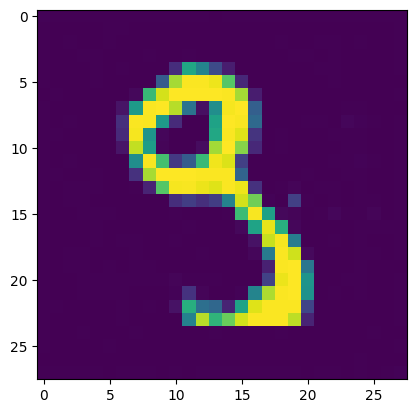

In [16]:
show_image(generated_images, idx=0)

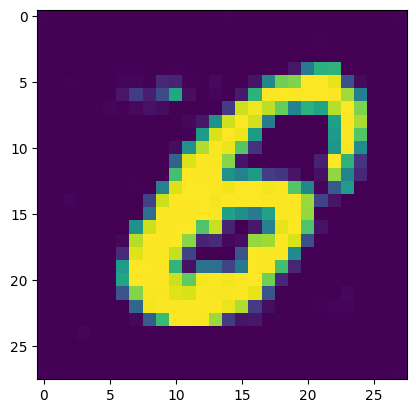

In [17]:
show_image(generated_images, idx=1)

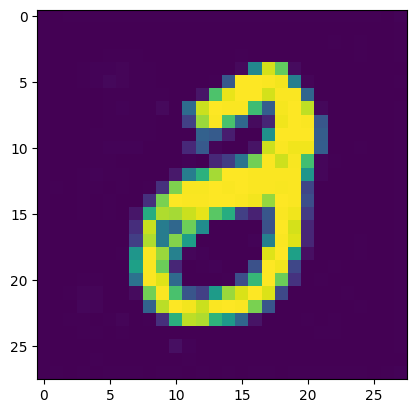

In [18]:
show_image(generated_images, idx=2)

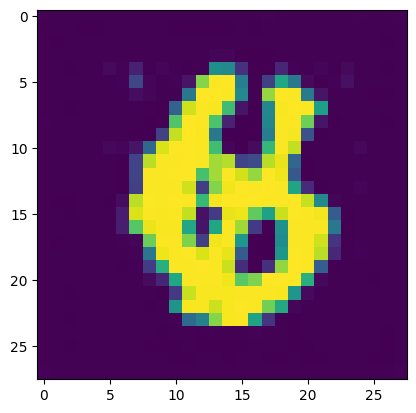

In [19]:
show_image(generated_images, idx=3)

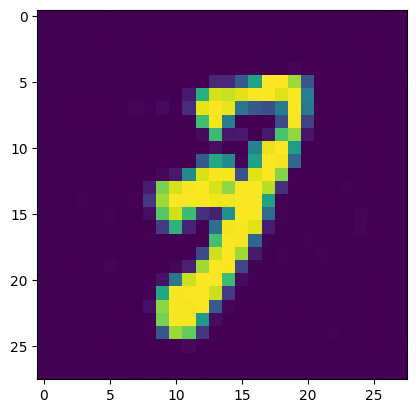

In [20]:
show_image(generated_images, idx=4)

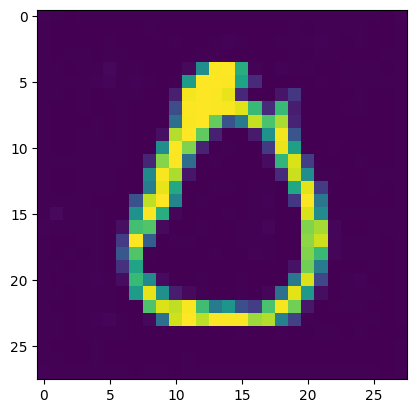

In [21]:
show_image(generated_images, idx=5)

### Comparison with ground-truth samples

In [22]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

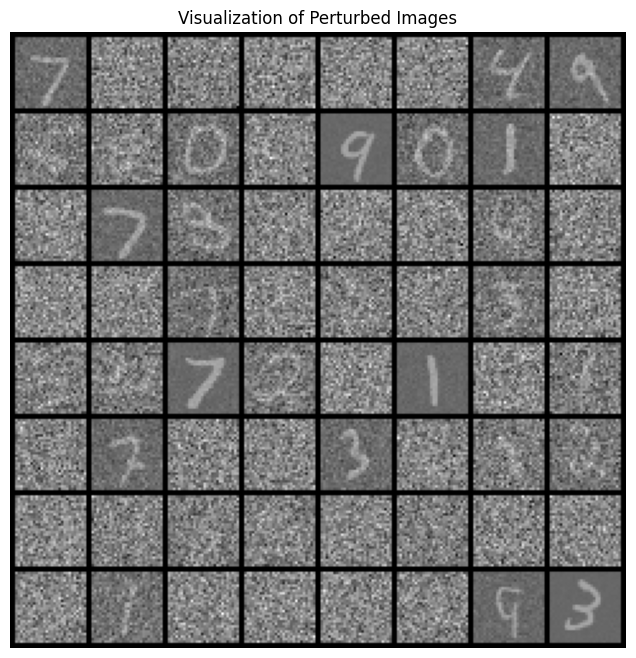

In [23]:
draw_sample_image(perturbed_images, "Perturbed Images")

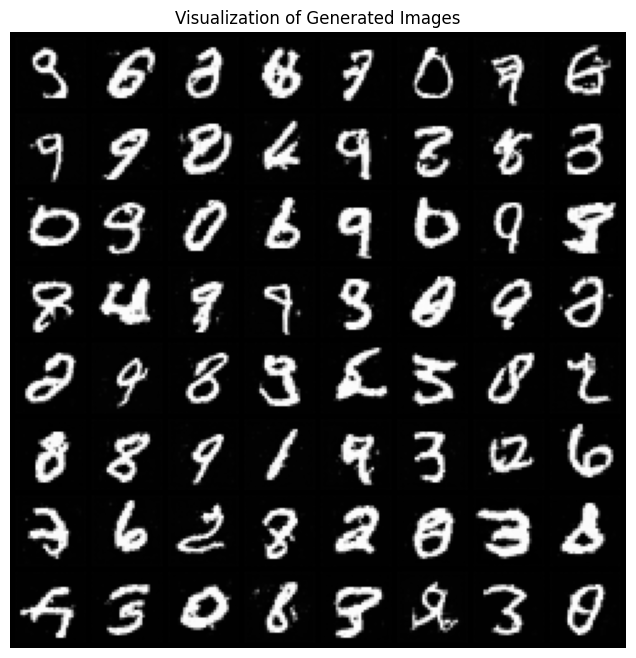

In [24]:
draw_sample_image(generated_images, "Generated Images")

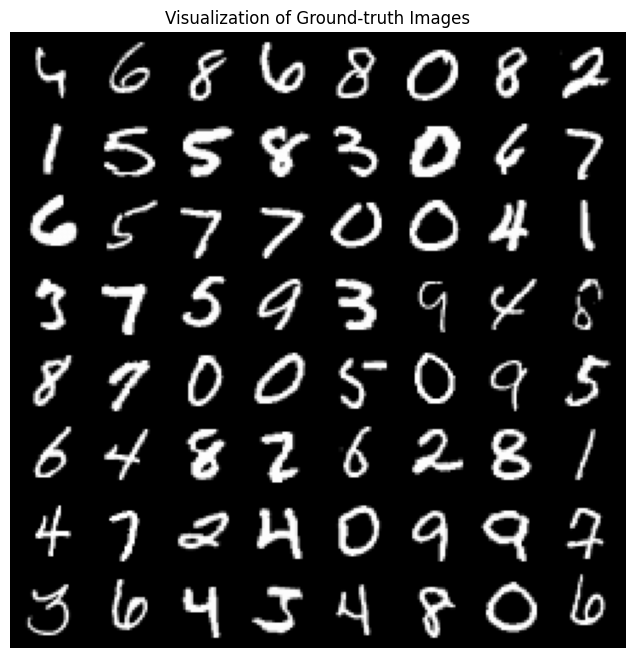

In [25]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")